In [34]:
#Imports
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
import datetime as dt
import praw
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#allows all columns to be scrolled
pd.set_option('display.max_columns', None)

# Source:https://stackoverflow.com/questions/47022070/display-all-dataframe-columns-in-a-jupyter-python-notebook/47022213 

In [3]:
#displays all text in dataframes
pd.set_option('display.max_colwidth', None)

# https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin

# Read In Our Data

In [4]:
alexa_google = pd.read_csv('./data/alexa_google_cleaned.csv')

# Modeling

## Train test split

In [5]:
X = alexa_google['text']
y = alexa_google['class']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

## Baseline Score

In [7]:
y.value_counts(normalize=True)

1    0.509184
0    0.490816
Name: class, dtype: float64

### Our baseline is to predict correct more than 50% of the time

-----------

# Logistic Regression

### To create more of a challenge, we are going to remove some of the most common words from the dataset such as `"google"` and `"alexa"`

## Create Stopwords

In [8]:
extra_stopwords = ['alexa',
 'echo',
 'amazon',
 'dot',
 'google',
 'home',
 'nest',
 'assistant']

In [9]:
#get the english stopwords
new_stopwords = nltk.corpus.stopwords.words('english')

#add our stopwords
new_stopwords.extend(extra_stopwords)

#Code adapted from Noah C at General Assembly

# Modeling

### Pipeline

Going to add `CountVectorizer` with my `new_stopwords` to remove the common words from the dataset

In [10]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords)), #use our new stopwords
    ('lr', LogisticRegression())
])

### Keep track of GridsearchCV runs

In [11]:
model_params_lr = {}
count_lr = 0

In [12]:
#Scaffolding
pipe_params_lr = {
    'cvec__max_features' : [2000, 3000, 4000, 5000], 
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [.90,95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

gs_lr = GridSearchCV(pipe_lr, # what object are we optimizing?
                  param_grid=pipe_params_lr, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

gs_lr.fit(X_train, y_train)

#this takes the best params dictionary and adds a column called score
gs_lr.best_params_['score'] = gs_lr.best_score_

#make a counter
count_lr +=1

#create new column with best params
model_params_lr[f'model_{count_lr}'] = gs_lr.best_params_

#orient sideways
model_lr_df = pd.DataFrame.from_dict(model_params_lr, orient='index')
model_lr_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score
model_1,0.9,3000,2,"(1, 2)",0.753741


In [13]:
gs_lr.best_score_ ##cross validated

0.7537414965986393

In [14]:
print(f'Train accuracy: {gs_lr.score(X_train, y_train)}')
print(f'Test accuracy: {gs_lr.score(X_test, y_test)}')

Train accuracy: 0.9884353741496599
Test accuracy: 0.7306122448979592


### Our model is very overfit. Where are we having the most trouble?

In [15]:
preds_lr = gs_lr.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_lr).ravel()

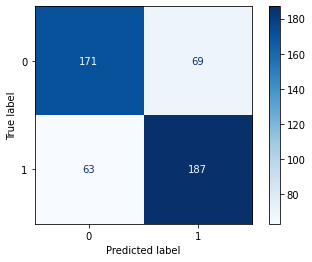

In [16]:
# View confusion matrix
plot_confusion_matrix(gs_lr, X_test, y_test, cmap='Blues', values_format='d');

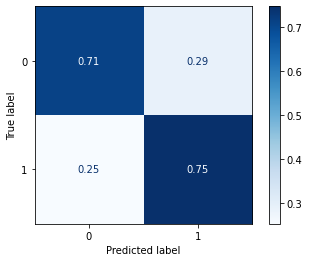

In [17]:
# View normalized confusion matrix
plot_confusion_matrix(gs_lr, X_test, y_test, cmap='Blues', normalize='true');

# Random Forest

In [18]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords)), #use new stopwords
    ('rf', RandomForestClassifier())
])

In [19]:
model_params = {}
count = 0

In [20]:
#Scaffolding

params_rf = {
    'rf__n_estimators' : [85,90,95], #number of trees
    'rf__max_features' : [None], 
    'rf__max_depth' : [6]
    
}

gs_rf = GridSearchCV(pipe_rf, 
                 param_grid=params_rf,
                 cv=5)

gs_rf.fit(X_train, y_train)

#this takes the best params dictionary and adds a column called score
gs_rf.best_params_['score'] = gs_rf.best_score_

#make a counter
count +=1

#create new column with best params
model_params[f'model_{count}'] = gs_rf.best_params_

#orient sideways
model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df

#adapted from DSI lesson 

,rf__max_depth,rf__max_features,rf__n_estimators,score
model_1,6,None,95,0.709524


In [21]:
print(f'Train accuracy: {gs_rf.score(X_train, y_train)}')
print(f'Test accuracy: {gs_rf.score(X_test, y_test)}')

Train accuracy: 0.7285714285714285
Test accuracy: 0.6693877551020408


## Our model is still performing above the baseline, but let's investigate how we might get a better prediction

---------

# Most Frequent Words

In [22]:
def most_freq(subreddit):
    
    #instantiate CountVectorizer
    cvec_df = CountVectorizer(stop_words=new_stopwords)
    
    #select subreddit and fit
    X_series = alexa_google[alexa_google['subreddit'] == subreddit]['text']
    X_series =  cvec_df.fit_transform(X_series)
    
    #convert to a dataframe
    X_df = pd.DataFrame(X_series.toarray(),
    columns=cvec_df.get_feature_names())
    
    # create empty dictionary
    top_words = {}

    # loop through columns
    for i in X_df.columns:
        # save sum of each column in dictionary
        top_words[i] =  X_df[i].sum()

    # top_words to dataframe sorted by highest occurance
    most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))
    
    return most_freq

### GoogleHome

In [23]:
google_most_freq =  most_freq('googlehome')

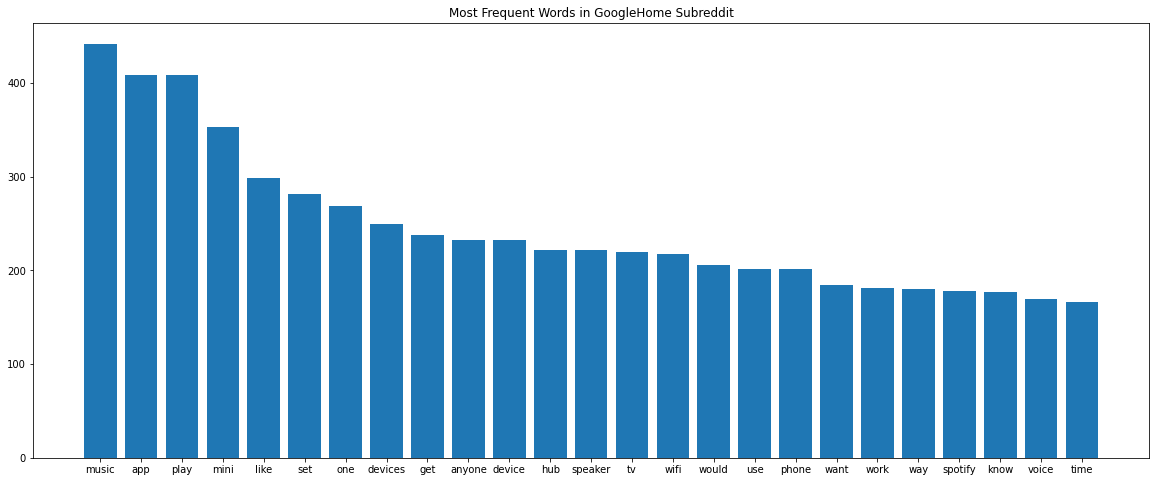

In [24]:
plt.figure(figsize=(20,8))
plt.bar(google_most_freq[0][:25], google_most_freq[1][:25])
plt.title('Most Frequent Words in GoogleHome Subreddit');

### Alexa

In [25]:
alexa_most_freq = most_freq('alexa')

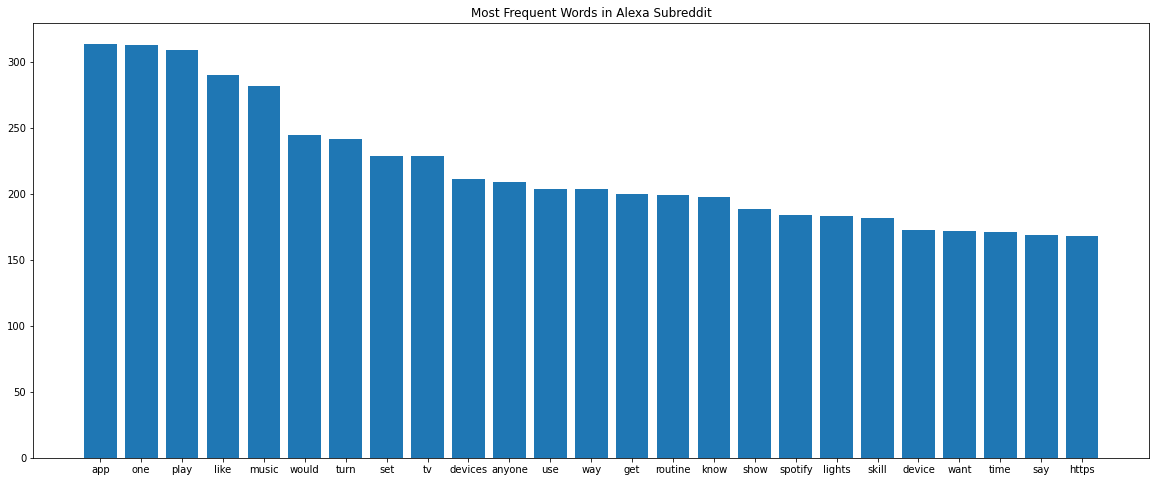

In [26]:
plt.figure(figsize=(20,8))
plt.bar(alexa_most_freq[0][:25], alexa_most_freq[1][:25])
plt.title('Most Frequent Words in Alexa Subreddit');

# Improving Random Forest with Bagging/Boosting and The Voting Classifier

In [27]:
#start timer
t0 = time.time()

#create a voting classifier
vote = VotingClassifier([
      ('bag', BaggingClassifier()),
    ('ada', AdaBoostClassifier()),
    ('rf', RandomForestClassifier()),
#     ('svc', LinearSVC(max_iter=3000))
])

#create a pipeline
pipe_boost = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords)),
    ('vote', vote)
])


#will want to run through GridSearchCV

params_boost = {
    'vote__ada__n_estimators' : [65],
    'vote__bag__n_estimators' : [75,80],
    'vote__rf__n_estimators' : [95],
    'vote__rf__max_features' : [None], 
    'vote__rf__max_depth' : [6]
}

gs_boost = GridSearchCV(pipe_boost,
                 param_grid=params_boost,
                 cv=5,
                 n_jobs=8)

gs_boost.fit(X_train, y_train)
print(f'Duration: {(time.time() - t0)/ 60} min')

gs_boost.best_params_

Duration: 0.5662230968475341 min


{'vote__ada__n_estimators': 65,
 'vote__bag__n_estimators': 75,
 'vote__rf__max_depth': 6,
 'vote__rf__max_features': None,
 'vote__rf__n_estimators': 95}

In [28]:
print(f'Train accuracy: {gs_boost.score(X_train, y_train)}')
print(f'Test accuracy: {gs_boost.score(X_test, y_test)}')

Train accuracy: 0.8850340136054422
Test accuracy: 0.7326530612244898


# Naive Bayes

In [29]:
pipe_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords)),
    ('nb',MultinomialNB())
])



In [30]:
model_params_nb = {}
count_nb = 0

In [31]:
#Scaffolding
pipe_params_nb = {
    'cvec__max_features' : [2000,2500,5000], 
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [95],
    'cvec__ngram_range' : [(1,2)]
}

gs_nb = GridSearchCV(pipe_nb, # what object are we optimizing?
                  param_grid=pipe_params_nb, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

gs_nb.fit(X_train, y_train)

#this takes the best params dictionary and adds a column called score
gs_nb.best_params_['score'] = gs_nb.best_score_

#make a counter
count_nb +=1

#create new column with best params
model_params_nb[f'model_{count_nb}'] = gs_nb.best_params_

#orient sideways
model_nb_df = pd.DataFrame.from_dict(model_params_nb, orient='index')
model_nb_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score
model_1,95,5000,3,"(1, 2)",0.730612


In [32]:
print(f'Train accuracy: {gs_nb.score(X_train, y_train)}')
print(f'Test accuracy: {gs_nb.score(X_test, y_test)}')

Train accuracy: 0.9081632653061225
Test accuracy: 0.7428571428571429


# Conclusion: The Logistic Regression model was my best performing model, depending on how much variance you are okay with.